In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)





In [7]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
results = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
results


('2017-08-23')

In [12]:
# Calculate the date 1 year ago from the last data point in the database
year_ago_date = dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago_date

datetime.date(2016, 8, 23)

In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
results = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).\
    filter(and_(Measurement.date >= '2016-08-23', Measurement.date <= '2017-08-23'))
results

# Perform a query to retrieve the data and precipitation scores
date = [result[0] for result in results[:]]
prcp = [result[1] for result in results[:]]


# Save the query results as a Pandas DataFrame and set the index to the date column
weather_df = pd.DataFrame(results[:], columns=['date', 'prcp'])
weather_df.set_index('date', inplace=True, )
weather_df = weather_df[weather_df!=0].dropna()
weather_df = weather_df.groupby(['date']).mean()
weather_df

,prcp
date,
2016-08-23,0.542000
2016-08-24,1.555000
2016-08-25,0.108000
2016-08-26,0.025000
2016-08-27,0.106667
...,...
2017-08-19,0.090000
2017-08-20,0.010000
2017-08-21,0.290000


In [36]:
# Sort the dataframe by date


weather_asc_df = weather_df.sort_values(['date'], ascending=True)
weather_asc_df


,prcp
date,
2016-08-23,0.542000
2016-08-24,1.555000
2016-08-25,0.108000
2016-08-26,0.025000
2016-08-27,0.106667
...,...
2017-08-19,0.090000
2017-08-20,0.010000
2017-08-21,0.290000


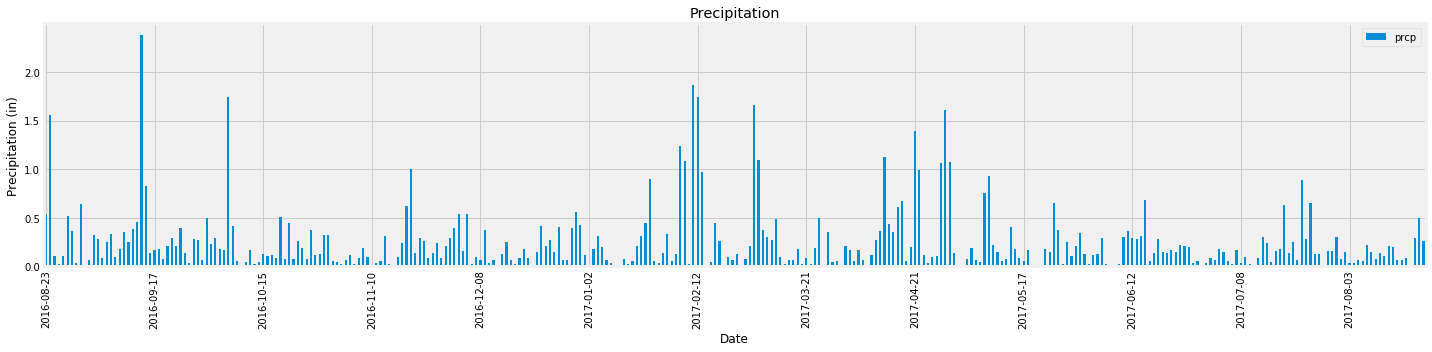

In [47]:

# weather_asc_df.iloc[::-1].plot.bar(title="emoji ranking")
# plt.tight_layout()
# plt.show()
# Use Pandas Plotting with Matplotlib to plot the data
ax = weather_asc_df.plot(kind = 'bar', title = 'Precipitation', figsize = (20,5))


n = 25

ticks = ax.xaxis.get_ticklocs()
ticklabels = [w.get_text() for w in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (in)")
plt.tight_layout()
#plt.style.use('fivethirtyeight')
plt.show()



In [38]:
# Use Pandas to calcualte the summary statistics for the precipitation data
weather_stats = weather_df.describe()
weather_stats

,prcp
count,318.000000
mean,0.248810
std,0.333069
min,0.010000
25%,0.060000
50%,0.141000
75%,0.294375
max,2.380000


In [39]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
stations

9

In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [41]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_stn_stats = session.query(Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
most_active_stn_stats

most_active_stn_stats_df = pd.DataFrame(most_active_stn_stats[:], columns=['Station', 'Low Temp', 'High Temp', 'Avg Temp'])
most_active_stn_stats_df.set_index('Station', inplace=True )
most_active_stn_stats_df

,Low Temp,High Temp,Avg Temp
Station,,,
USC00519281,54.0,85.0,71.663781


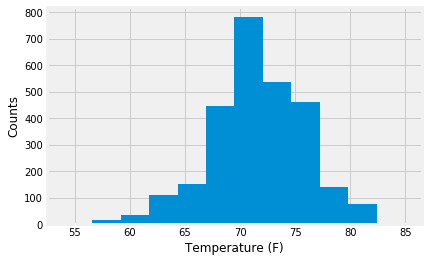

In [42]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_stn_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').order_by(Measurement.tobs.asc()).all()
#most_active_stn_temps

date = [most_active_stn_temps[0] for most_active_stn_temp in most_active_stn_temps[:]]
temp = [most_active_stn_temps[1] for most_active_stn_temp in most_active_stn_temps[:]]

temp_df = pd.DataFrame(most_active_stn_temps[:], columns=['date', 'temp'])
temp_df.set_index('date', inplace=True, )
temp_df

plt.hist(temp_df['temp'], bins = 12)
plt.xlabel('Temperature (F)')
plt.ylabel('Counts')
plt.show()



## Bonus Challenge Assignment

In [43]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
